# Celestial Mechanics - Homework 5
## Giacomo Menegatti - 2122852

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton
from math import factorial as fac
import matplotlib.cm as cmaps


### Initial conditions for Venus Flyby

In [102]:
R0 = np.array([-267733.084163, 199426.194677, 254709.414665]) # I use the upper case to indicate a vector
R1 = np.array([177071.935393, -334448.764629, -184024.725921])  #Final position
V0 = np.array([4.168950, -2.598877, -3.925639])
GM = 324859.2139518842890 


## Stumff's functions
The general form of a Stumff's function is $$c_n(z)=\sum_{k=0}^\infty (-1)^k\frac{z^k}{(2k+n)!} $$ that far from zero can be derived from a combination of trigonometric functions in the positive domain and hyperbolic ones in the negative domain. Around zero, to avoid errors in the computation, the series expansion is used. 

The first derivative is found applying the recursive relation $$ c'_{n}(z)=\frac{n}{2}c_{n+2}(z)-\frac{1}{2}c_{n+1}(z) $$

After studying where the computation starts to get unstable, I chosed $|z|<10^{-2}$ as a treshold for switching to the series computation, and considering that the precision is up to 15 digits in Python doubles, an expansion to $z^8$ is required as further terms would be $o(10^{-16})$.

In [103]:
# Functions in the positive part of the domain
pos_func = [lambda x: np.cos(x), lambda x: np.sin(x)/x, lambda x: (1-np.cos(x))/x**2, lambda x: (x-np.sin(x))/x**3, lambda x: (np.cos(x)-1+x**2/2)/x**4, lambda x: (np.sin(x)-x+x**3/6)/x**5]

# Functions in the negative part
neg_func = [lambda x: np.cosh(x), lambda x: np.sinh(x)/x, lambda x: (np.cosh(x)-1)/x**2, lambda x: (np.sinh(x)-x)/x**3, lambda x: (np.cosh(x)-1-x**2/2)/x**4, lambda x: (np.sinh(x)-x-x**3/6)/x**5]

def c(z, n=0):
  if np.abs(z)<1e-2:
    return sum((-z)**k/fac(2*k+n) for k in range(0, 8))
  elif z>0:
    return pos_func[n]((z)**0.5)
  else:
    return neg_func[n]((-z)**0.5)

def c_prime(z, n=0):
  return n/2*c(z, n=n+2)-1/2*c(z, n=n+1)


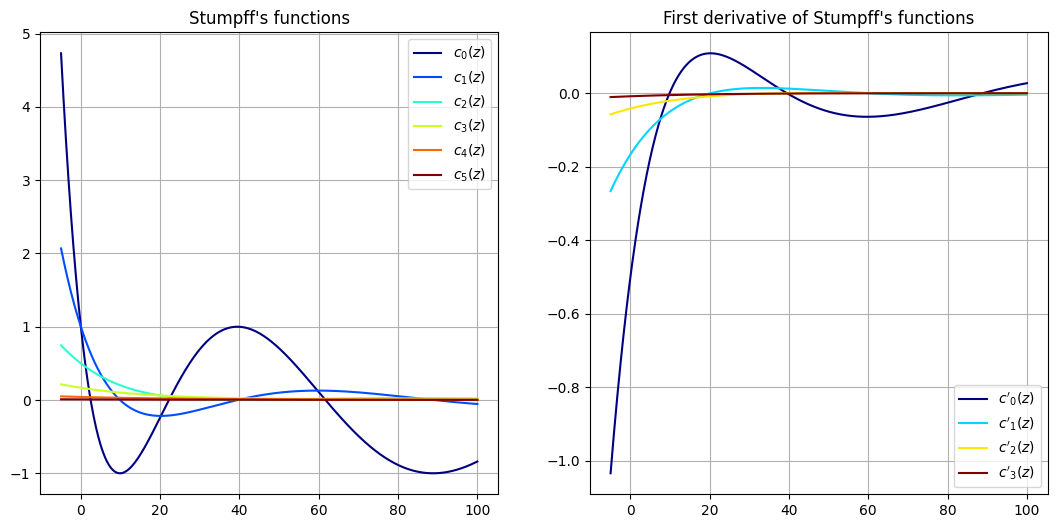

In [104]:
x = np.linspace(-5, 100, 1000)

fig, AX = plt.subplots(nrows=1, ncols=2, figsize=(13,6))

AX[0].set_title("Stumpff's functions")
for n, col in zip(range(0,6), cmaps.jet(np.linspace(0,1,6))):
  AX[0].plot(x, [c(z, n=n) for z in x], color=col,  label =f'$c_{n}(z)$')
AX[0].legend()
AX[0].grid()

AX[1].set_title("First derivative of Stumpff's functions")
for n, col in zip(range(0,4), cmaps.jet(np.linspace(0,1,4))):
  AX[1].plot(x, [c_prime(z, n=n) for z in x], color=col,  label =f"$c'_{n}(z)$")
AX[1].legend()
AX[1].grid()


## Universal Kepler's equation
The universal Kepler equation is $$ t(s)-t_0=r_0s + r_0 \dot r_0s^2 c_2(-2Cs^2)+(\mu+2r_0C)s^3c_3(-2Cs^2) $$ 
Implementing the Newton-Raphson's method gives $$ s_{n+1} = s_n +  \frac{\Delta t −[t(s_n) − t_0]}{r(s_n)} $$ as the recursive approximation, with starting point $s_0=0$ and the radius is expressed as $$ r(s) = r_0c_0
(−2Cs^2) + r_0 \dot r_0 s c_1(−2Cs^2) + \mu s^2c_2(−2Cs^2) $$ 
 
I found that the direct implementation of the Newton method is not working because the function becomes unstable after a certain point. To avoid this I used the Newton method implemented by the scipy package, which works fine.

In [105]:
def t_(s, t0, r0, dr0, C, mu):
  '''Time from t0 as a function of s'''
  z = -2*C*s**2
  return t0 + r0*s+r0*dr0*s**2*c(z, n=2) + (mu + 2*r0*C)*s**3*c(z, n=3)

def r_(s, t0, r0, dr0, C, mu):
  '''Radius as a function of s'''
  z = -2*C*s**2
  return r0*c(z, n=0) + r0*dr0*s*c(z, n=1) + mu*s**2*c(z, n=2)

def UKE_solve(t, t0, r0, dr0, C, mu):
  s = 0
  if t==t0:
    return 0  #If t=t0, s=0 so there is no need to compute it 
  else: 
    f = lambda s, t0, r0, dr0, C, mu: t-t_(s, t0, r0, dr0, C, mu)
    f_prime = lambda s, t0, r0, dr0, C, mu: -r_(s, t0, r0, dr0, C, mu)
    s = newton(f, x0=0, fprime=f_prime, args=(t0,r0,dr0,C,mu), rtol=1e-14)
  return s

def UKE_solve_wrong(t, t0, r0, dr0, C, mu, atol=1e-12, rtol=1e-12):
  '''Direct implementation of the newton method'''
  s = 0
  delta_rel, error = 1, 1
  if t==t0:
    return 0  #If t=t0, s=0 so there is no need to compute it 
  else: 
    while delta_rel>rtol or error>atol: 
      error = (t-t_(s=s, t0=t0, r0=r0, dr0=dr0, C=C, mu=mu))#distance from zero 
      delta = error/r_(s=s, t0=t0, r0=r0, dr0=dr0, C=C, mu=mu)
      s = s + delta
      delta_rel = delta/s #Relative change in s'''
  return s


### Comparison between the two solvers
The black dotted line represent the direct function $t(s)$, while the others are the inverse functions found by the solvers (plotted overimposed to the direct function to make comparison easier). The direct implementation works fine in a given interval but than starts to oscillate wildly. The reasons for this are not completely clear, probably the scipy method contains more safeguards to prevent this kind of behaviour.

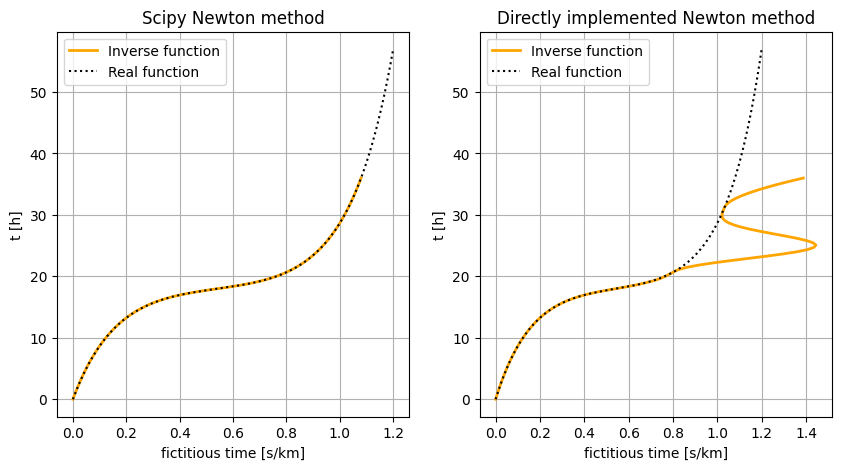

<Figure size 640x480 with 0 Axes>

In [106]:
r0 = np.linalg.norm(R0)
dr0 = np.dot(R0, V0)/r0         #dr0 is the radial component of the velocity
C = 0.5*np.dot(V0, V0) - GM/r0  #Constant of energy
T = np.linspace(0, 36*3600, 100)

s_list = [UKE_solve(t=t, t0=0.0, r0=r0, dr0=dr0, C=C, mu=GM) for t in T]
s_list_wrong = [UKE_solve_wrong(t=t, t0=0.0, r0=r0, dr0=dr0, C=C, mu=GM) for t in T]

# True function
S = np.linspace(0,1.2, 1000)
t_list = np.array([t_(s, 0, r0, dr0, C, GM) for s in S])
udm = 3600 #Plot the times in hours

fig, AX = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
AX[0].set_title('Scipy Newton method')
AX[0].plot(s_list, T/udm, color='orange', lw=2, label='Inverse function')

AX[1].set_title('Directly implemented Newton method')
AX[1].plot(s_list_wrong, T/udm, color='orange', lw=2, label='Inverse function')

AX[0].plot(S, t_list/udm, ls='dotted', color='k', label='Real function')
AX[1].plot(S, t_list/udm, ls='dotted', color='k', label='Real function')

AX[0].set_xlabel('fictitious time [s/km]')
AX[0].set_ylabel('t [h]')
AX[1].set_xlabel('fictitious time [s/km]')
AX[1].set_ylabel('t [h]')
AX[0].legend()
AX[0].grid()
AX[1].legend()
AX[1].grid()

plt.show()
plt.tight_layout()


## Venus Flyby 
The position and velocity at a given parameter $s$ are given by the universal Lagrange coefficients matrix
$$ \begin{pmatrix} \mathbf r \\ \mathbf{ \dot r} \end{pmatrix} = \begin{pmatrix} F & G \\ \dot F & \dot G \end{pmatrix} \begin{pmatrix} \mathbf r_0 \\ \mathbf{ \dot r}_0 \end{pmatrix} $$
 with

$$ F = 1 − \frac{\mu}{r_0}s^2c_2(−2Cs^2) $$
$$ G = r_0s c_1(−2Cs^2) + r_0 \dot r_0 s^2c_2(−2Cs^2) $$
$$ \dot F = − \frac{μ}{r(s)r_0}s c_1(−2Cs^2) $$
$$ \dot G = \frac{r_0}{r(s)}c_0(-2Cs^2) + \frac{r_0 \dot r_0}{r(s)}sc_1(−2Cs^2) $$ 

In [107]:
def ULM(s, r0, dr0, C, mu):
  '''Universal Lagrange Matrix'''
  z = -2*C*s**2
  r = r_(s=s, t0=0, r0=r0, dr0=dr0, C=C, mu=mu)

  F = 1.0 - mu/r0*s**2*c(z, n=2)
  G = r0*s*c(z, n=1) + r0*dr0*s**2*c(z, n=2)
  dF = -mu/(r*r0)*s*c(z, n=1)
  dG = r0/r*c(z, n=0) + r0*dr0/r*s*c(z, n=1)
  return np.array([F, G, dF, dG])

def get_orbit(T, mu, R0, V0):
  '''Get position and velocity during an orbit'''
  r0 = np.linalg.norm(R0)
  dr0 = np.dot(R0, V0)/r0         #dr0 is the radial component of the velocity
  C = 0.5*np.dot(V0, V0) - mu/r0  #Constant of energy
 
  s_list = [UKE_solve(t=t, t0=0.0, r0=r0, dr0=dr0, C=C, mu=mu) for t in T] #List that contains the fictitiuos times

  ULMs = np.array([ULM(s=s, r0=r0, dr0=dr0, C=C, mu=mu) for s in s_list])
  R = np.array([ulm[0]*R0+ulm[1]*V0 for ulm in ULMs])
  V = np.array([ulm[2]*R0+ulm[3]*V0 for ulm in ULMs])
  return R, V


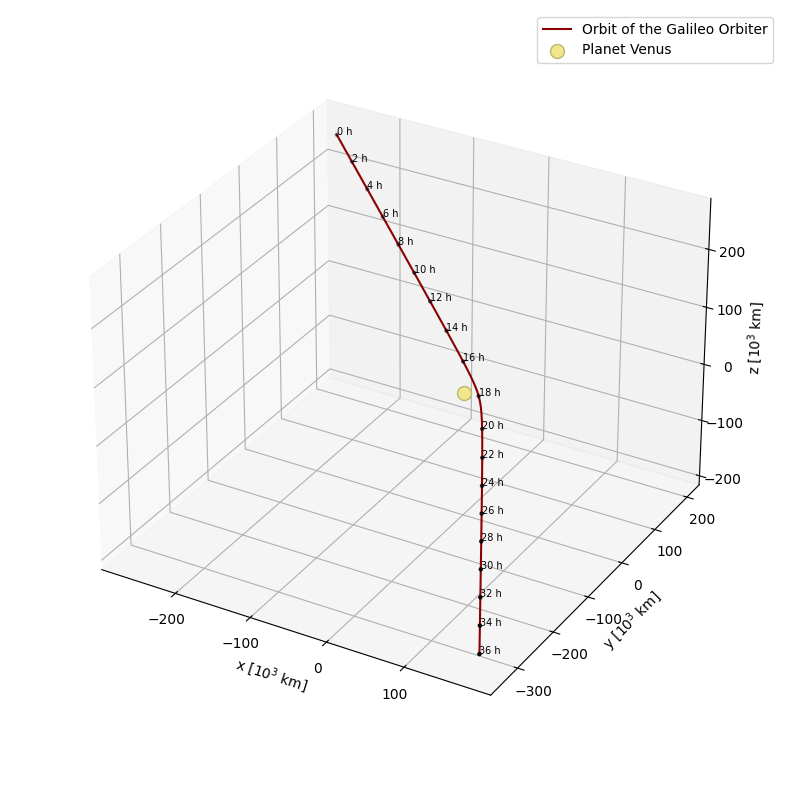

In [108]:
T = np.linspace(0, 36*3600, 1001)
T_hours = np.arange(0, 37, 2)

R, V = get_orbit(T, GM, R0, V0)
R_hours, _ = get_orbit(3600*T_hours, GM, R0, V0)

udm = 1e3
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot(R[:,0]/udm, R[:,1]/udm, R[:,2]/udm, color='darkred', label='Orbit of the Galileo Orbiter')

ax.scatter(R_hours[:,0]/udm, R_hours[:,1]/udm, R_hours[:,2]/udm, marker='.', color='k')
[ax.text(R[0]/udm, R[1]/udm, R[2]/udm, f'{hour} h', fontsize=7) for R, hour in zip(R_hours, T_hours)]

ax.scatter(0,0,0, marker='o', color='khaki', edgecolors='darkkhaki', s=100, label='Planet Venus')
ax.legend()
ax.set_xlabel('x [$10^3$ km]')
ax.set_ylabel('y [$10^3$ km]')
ax.set_zlabel('z [$10^3$ km]')
ax.set_box_aspect(aspect=None, zoom=0.9)
plt.tight_layout()
plt.show()


In [109]:
R, V = get_orbit(T=[36*3600], mu=GM, R0=R0, V0=V0)
print('The final dynamical state is :')
print('R: ', R[0], '[km]')
print('V: ', V[0], '[km/s]' )
dist = np.linalg.norm(R[0]-R1)
print(f'\n The distance from the true value R:{R1} [km], is {dist} km')


The final dynamical state is :
R:  [ 176956.9297027  -334433.44069937 -184558.85545376] [km]
V:  [ 2.36979447 -5.24495423 -2.53289844] [km/s]

 The distance from the true value R:[ 177071.935393 -334448.764629 -184024.725921] [km], is 546.5852992835572 km


## Universal Lambert's Equation
The Universal Lambert's equation gives the energy constant needed to orbit from $r_0$ to $r$ in a given time:
$$ t − t_0 = A \sqrt{s^2c_2 (z)} + \mu s^3c_3 (z) $$
$$ A = \frac{\sqrt{r_0r_t}\sin \Delta f}{\sqrt{1-\cos \Delta f}} $$
$$ s^2 = \frac{1}{\mu c_2(z)}\left[r_0+r_t-A\frac{c_1(z)}{\sqrt{c_2(z)}}\right] $$
The first equation can be combined with the third to find $z$ at time $t$.  
To do this, I have used the Newton-Raphson method $x_{n+1} = x_n-\frac{f(x_n)}{f'(x_n)}$, where the function to found the root of is $t(z)-t0-\Delta t$. The derivative of $t(z)-t_0$ w.r.t $z$ is $$ \frac{A^2}{8\mu s}+ \frac{3sc_3(z)}{2c_2(z)}\left( \frac{A\sqrt{c_2(z)}}{4}-\mu s^2 c'_2(z)\right) + \mu s^3 c'_3(z) $$ The chosen starting point is $z=0$. I used the scipy Newton method because I consider it safer, given the previous problem. The direct implementation here gave the same result as scipy, but may fail on another interval.

The initial velocity can be found by inverting $\mathbf r = F \mathbf r_0 + G \mathbf{\dot r}_0$ with
$$ F = 1 − \frac{\mu}{r_0}s^2c_2(z)$$
$$ G = t − t_0 − \mu s^3 c_3 (z) $$

In [110]:
def solve_Lambert(R0, R, Dt, mu, tol=1e-12):
  r0 = np.linalg.norm(R0)
  r = np.linalg.norm(R)
  Df = np.arccos(np.dot(R, R0)/(r*r0))   #Change in true anomaly
  
  A = (r0*r)**0.5*np.sin(Df)/(1-np.cos(Df))**0.5

  s_ = lambda z: ((r0+r-A*c(z, n=1)/((c(z, n=2))**0.5))/(mu*c(z, n=2)))**0.5
  f = lambda z: A*s_(z)*c(z, n=2)**0.5 + mu*s_(z)**3*c(z, n=3) - Dt

  f_prime = lambda z: A**2/(8*mu*s_(z)) + 3*s_(z)*c(z, n=3)/(2*c(z, n=2))*(A/4*(c(z, n=2)**0.5) - mu*s_(z)**2*c_prime(z, n=2)) + mu*s_(z)**3*c_prime(z, n=3)

  z = newton(f, x0=0, fprime=f_prime, rtol=1e-12)
  
  F = 1.0 - mu/r0*s_(z)**2*c(z, n=2)
  G = Dt - mu*s_(z)**3*c(z, n=3)

  V0 = (R-F*R0)/G
  
  return V0


## Solving the Lambert's equation for the Venus Flyby

In [111]:
V = solve_Lambert(R0, R1, 36*3600, GM)
print(f'The initial velocity found by the Lambert equation is {V} [km/s]')
print(f'The real value is {V0} [km/s]')
print(f'The velocity difference is {V0-V} km/s (with magnitude {np.linalg.norm(V0-V)} km/s)')


The initial velocity found by the Lambert equation is [ 3.13466068 -4.3618355  -3.1379475 ] [km/s]
The real value is [ 4.16895  -2.598877 -3.925639] [km/s]
The velocity difference is [ 1.03428932  1.7629585  -0.7876915 ] km/s (with magnitude 2.1904873779353964 km/s)


In [112]:
R_V, _ = get_orbit([36*3600], GM, R0, V)
print(f'The final position with this velocity is {R_V[0]} km,')
R_V0, _ = get_orbit([36*3600], GM, R0, V0)
print(f'while the one found in the propagation is {R_V0[0]} km')


The final position with this velocity is [ 177071.935393 -334448.764629 -184024.725921] km,
while the one found in the propagation is [ 176956.9297027  -334433.44069937 -184558.85545376] km


The initial velocity found by the Lamber equation is much different than the one found before, but the final position is exactly the one desired (while propagating with $V_0$ gave an error on the final position of over 500 km). Thus I can conclude that is not an error in computation but it's due to the fact that the system is heavily perturbed by the other celestial bodies (Sun and other planets), so solving it as a 2-body problem gives always an error in prediction, either using the real initial velocity to propagate to the final position or using the real final position to predict the initial velocity.